# DSB baseline

## Version 

* Ver 25 : new_train_v6(ver 24) + len P
* Ver 26 : new_train_v8 + model P
* Ver 27 ~ 33 : new_train_v9 + model P + Reg Optimizer

## Result

1. Classification and Regression
2. model predict and len_predict
3. Opimizier


* new_train_v7(V.23), model P : 0.534,
* new_train_v6(V.24), model P : 0.541
* new_train_v5(V.16), len P : 0.540
* new_train_v3(V.17), len P : 0.538
* new_train_v3(V.12), model P : 0.537
* new_train_v3(V.10), not dummy data, model P : 0.432

* 대회 목표(competiton goals) : test에서 주어진 installation_id의 최종 accuracy_group 을 맞추기
    -> 단, train set에는 전체 log가 주어지지만, test set에서는 random하게 일부분만 주어짐.
    
* Loss function : quadratic kappa score

** 생각해볼점 **

1. installation_id 에서 사용자의 특성을 추출할 수 있을까? -> 클러스터링으로 사용자를 묶을 수 있을까?
2. 대부분의 상관계수는 0.1 이하로 나타난다...

In [1]:
# Any results you write to the current directory are saved as output.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GroupKFold, KFold
import gc
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tqdm
from tqdm import tqdm_notebook
import os


from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from random import choice

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb

import tensorflow as tf

from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

import gc
import json

#Print control function
print('Set print')
def print_expand():
    pd.set_option('display.max_columns', None)  # or 1000
    pd.set_option('display.max_rows', 100)  # or 1000
    pd.set_option('display.max_colwidth', -1)  # or 199
    
def print_basic():
    pd.set_option('display.max_columns', 30)  # or 1000
    pd.set_option('display.max_rows', 30)  # or 1000
    pd.set_option('display.max_colwidth', 50)  # or 199
    
def train_print(col, name):
    temp = train[train[col] == name]
    return temp

def specs_print(name):
    display(specs[specs['event_id'] == name])

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Set print


In [2]:
%%time
# Read in the data CSV files
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

# Use train data just in train_labels
ids = train_labels.installation_id.unique()
train = train[train['installation_id'].isin(list(ids))].reset_index(drop=True)

#Type change
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

CPU times: user 1min 28s, sys: 12.1 s, total: 1min 40s
Wall time: 1min 40s


# Make testset

## Define list

In [3]:
list_of_world = ['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']
list_of_types = ['Clip', 'Game', 'Activity', 'Assessment']
list_of_event_code = np.sort(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
list_of_assess = list(train[train.type == 'Assessment'].title.unique())
list_of_titles = list(train.title.unique())
list_of_game = train[train.type == 'Game'].title.unique()
list_of_clip = train[train['type'] == 'Clip']['title'].unique()
list_of_activity = train[train['type'] == 'Activity']['title'].unique()

#Covert diff last data in installation_id.
clip_time = pd.read_csv('../input/new-train/media_sequence.csv')
clip_time = clip_time[clip_time['type'] == 'Clip'][['title', 'duration']]
clip_time = clip_time.set_index('title').to_dict()['duration']

print('Assessment process list')
mushroom_before = ['Tree Top City - Level 1',
                    'Ordering Spheres',
                    'All Star Sorting',
                    'Costume Box',
                    'Fireworks (Activity)',
                    '12 Monkeys',
                    'Tree Top City - Level 2',
                    'Flower Waterer (Activity)',
                    "Pirate's Tale"]
                   
bird_before = ['Tree Top City - Level 1',
                'Ordering Spheres',
                'All Star Sorting',
                'Costume Box',
                'Fireworks (Activity)',
                '12 Monkeys',
                'Tree Top City - Level 2',
                'Flower Waterer (Activity)',
                "Pirate's Tale",
                'Mushroom Sorter (Assessment)',
                'Air Show',
                'Treasure Map',
                'Tree Top City - Level 3',
                'Crystals Rule',
                'Rulers',
                'Bug Measurer (Activity)']


cauldron_before =['Magma Peak - Level 1',
                'Sandcastle Builder (Activity)',
                'Slop Problem',
                'Scrub-A-Dub',
                'Watering Hole (Activity)',
                'Magma Peak - Level 2',
                'Dino Drink',
                'Bubble Bath',
                'Bottle Filler (Activity)',
                'Dino Dive']


chest_before=['Crystal Caves - Level 1',
            'Chow Time',
            'Balancing Act',
            'Chicken Balancer (Activity)',
            'Lifting Heavy Things',
            'Crystal Caves - Level 2',
            'Honey Cake',
            'Happy Camel',
            'Cart Balancer (Assessment)',
            'Leaf Leader',
            'Crystal Caves - Level 3',
            'Heavy, Heavier, Heaviest',
            'Pan Balance',
            'Egg Dropper (Activity)']
             
             
cart_before=['Crystal Caves - Level 1',
            'Chow Time',
            'Balancing Act',
            'Chicken Balancer (Activity)',
            'Lifting Heavy Things',
            'Crystal Caves - Level 2',
            'Honey Cake',
            'Happy Camel']

Assessment process list


## Fix data

In [4]:
print('Fix train')
def make_correct(df):
    round_list = []
    level_list = []
    correct_list = []
    
    for i in df['event_data']:
        value = json.loads(i)
        try:
            correct_list.append(value['correct'])
        except:
            correct_list.append(None)   
        try:
            round_list.append(value['round'])
        except KeyError as key:
            round_list.append(None)
        try:
            level_list.append(value['level'])
        except KeyError as key:
            level_list.append(None)
    return round_list, level_list, correct_list

def correct_fix(train):
    ## Dino_Drink ##
    #temp = train[(train['title'] == 'Dino Dive') & (train['correct'] == True)]
    temp = train.query("(title=='{}')&(correct==True)".format('Dino Dive'))
    next_temp = train.loc[temp.index+1, 'event_data'].str.contains('Try choosing')
    train.loc[train.loc[next_temp[next_temp == True].index].index -1, 'correct'] = False
    ## Leaf Leader ##
    temp = train.query("(title=='{}')&(correct==True)".format('Leaf Leader'))
    next_temp = train.loc[temp.index+1, 'event_data'].str.contains('too')
    train.loc[train.loc[next_temp[next_temp == True].index].index -1, 'correct'] = False
    return train

#diff -> 다음 acttion 사이의 시간 
def diff(train):
    train['diff'] = train['timestamp'].diff()
    train['diff'] = train['diff'].dt.total_seconds()
    t = list(train['diff'][1:])
    t.append(0)
    train['diff'] = t
    #Save except values
    def save_except(train=train): #다음 데이터와 installation_id가 같고, game_session이 다르다면 초기값으로 설정한다.
        #temp = train.loc[(train['diff'] < 0) | (train['diff'] >= 1800)]
        temp = train.query("(diff<0)|(diff>=1800)")
        next_temp = train.loc[temp.index+1]
        iloc_idx = []
        for num, (t_se, t_id, nt_se, nt_id) in enumerate(zip(temp['game_session'], temp['installation_id'], next_temp['game_session'], next_temp['installation_id'])):
            if (t_se != nt_se) &(t_id == nt_id):
                iloc_idx.append(num)
        value = temp.iloc[iloc_idx]['diff']
        return value
    
    #Convert diff data over 30 minute or minus value.
    #value = save_except(train)
    #train.loc[(train['diff'] < 0) | (train['diff'] >= 1800),'diff'] = 0
    #train.query("(diff<0)|(diff>=1800)")['diff'] = 0
    #train.loc[value.index, 'diff'] = value
    
    k = train[['installation_id', 'title', 'diff']].reset_index().groupby('installation_id', sort=False).last()
    k['diff'] = k['title'].map(clip_time)
    k['diff'].fillna(0, inplace=True)
    train.loc[list(k['index']), 'diff'] = list(k['diff']) #Regard last Clip is finished. Just give 5 minute values to over time threshould
    return train['diff']

#2. fix outlier
def diff_outlier(train):
    out_df = train[train['diff'] >= 1800]
    last_idx = train.reset_index().groupby('game_session')['index'].last()
    train.loc[list(out_df.index[out_df.index.isin(last_idx) != True]), 'diff'] = 0
    return train['diff']   

#4. Change last session diff to zero
def diff_change(train):
    train = train.reset_index()
    last_idx = train[train['type'] != 'Clip'].groupby('game_session')['index'].last()
    train.loc[list(last_idx), 'diff'] = 0
    
    clip_idx = list(train[(train['diff'] >= 180) & (train['type'] == 'Clip')].index)
    train.loc[clip_idx, 'diff'] = train.loc[clip_idx, 'title'].map(clip_time)
    return train['diff']

def process_category(x):
    if x in mushroom_before:
        return 0
    elif x in bird_before:
        return 1
    elif x in cauldron_before:
        return 2
    elif x in cart_before:
        return 3
    elif x in chest_before:
        return 4

Fix train


In [5]:
%%time
'''train['round'], train['level'], train['correct'] = make_correct(train)
train = correct_fix(train)

train['diff'] = diff(train)
train['diff'] = diff_outlier(train)
train['diff2'] = diff_change(train)
train['process'] = train['title'].apply(process_category)'''


test['round'], test['level'], test['correct'] = make_correct(test)
test = correct_fix(test)

test['diff'] = diff(test)
test['diff'] = diff_outlier(test)
test['diff2'] = diff_change(test)
test['process'] = test['title'].apply(process_category)

CPU times: user 19.2 s, sys: 477 ms, total: 19.7 s
Wall time: 19.3 s


## Delete low session

In [6]:
test['4_code'] = test['event_code'].apply(lambda x : 1 if (x >= 4000) & (x<5000) else 0)

cc = test.groupby('game_session')['4_code'].sum()
session = cc[cc == 0].index

temp = test[(test['game_session'].isin(session)) & (test['type'] !='Clip')]

session2 = test.groupby('installation_id')['game_session'].last()
temp = temp[temp['game_session'].isin(session2) != True]

In [7]:
test.drop(temp.index, inplace=True)
test = test.reset_index(drop=True)

## Basic columns

In [8]:
print('basic columns functions')
#All game time, before Assessment start.
def game_time(df):
    #df.groupby('game_session')['game_time'].max().sum() / 1000
    return df[:-1]['diff2'].sum()

#Time gap bewteen Assessment and previous session
def time_gap(df, session):
    try:
        time = pd.Timedelta(df.iloc[-1]['timestamp'] - df.iloc[-2]['timestamp']).total_seconds()
    except:  #except only one Assessment 
        print('Except time_gap F, session = {}, len : {}'.format(session, len(df)))
        time = 0 
    return time

#Start time to last time
def total_time(df, session):
    try:
        time = pd.Timedelta(df.iloc[-1]['timestamp'] - df.iloc[0]['timestamp']).total_seconds()
        #time = df[:-1]['diff2'].sum()
    except:  #except only one Assessment 
        print('Except total_time F, session = {}, len : {}'.format(session, len(df)))
        time = 0 
    return time

def time_percentage(game_time, total_time):
    try:
        time = np.round((game_time / total_time), 4)
    except ZeroDivisionError:
        time = 0
    return time

def type_time_per(df, list_of_types=list_of_types):
    col = dict()
    for i in list_of_types:
        name = i + '_time_per'
        col[name] = 0
        
    for t, df in df.groupby('type', sort=False):
        time = df['diff2'].sum()
        col["{}_time_per".format(t)] = time
    
    data = list(col.values())
    data /= np.sum(data)
    return np.round(data, 4)

# Number of type
def type_count(df):
    type_count = dict({'Activity':0, 'Assessment':0, 'Clip':0, 'Game':0})
    #type_dict = dict(df.groupby('type').agg('nunique')['title'])
    type_dict = dict(df.groupby('type')['title'].agg('nunique'))
    
    for i in type_dict:
        type_count[i] = type_dict[i]
    return type_count

#Assessment 과정 수행률
def process_score(df):
    score = [0,0,0,0,0]
    
    for i in df.title.unique():
        if i in mushroom_before:
            score[0] += 1
        if i in bird_before:
            score[1] += 1
        if i in cauldron_before:
            score[2] += 1
        if i in chest_before:
            score[3] += 1
        if i in cart_before:
            score[4] += 1
    
    score_per = score.copy()
    score_per[0] = score_per[0] / 9
    score_per[1] = score_per[1] / 16
    score_per[2] = score_per[2] / 10
    score_per[3] = score_per[3] / 14
    score_per[4] = score_per[4] / 8
    return score, np.round(score_per, 4)

def session_count(df):
    count = df.game_session.nunique()
    return count

#Count event_code
def event_code_count(df, list_of_event_code=list_of_event_code):
    #code_list = df.groupby('event_code').count()['installation_id']
    code_list = df.groupby('event_code')['installation_id'].count()
    code_dict = dict()
    for i in list_of_event_code:
        if i in code_list:
            code_dict[i] = code_list[i]
        else:
            code_dict[i] = 0
    return code_dict

#Count event_code
def title_count(df, list_of_event_code=list_of_titles):
    code_list = dict(Counter(df.groupby('game_session')['title'].first()))
    code_dict = dict()
    for i in list_of_event_code:
        if i in code_list:
            code_dict[i] = code_list[i]
        else:
            code_dict[i] = 0
    return code_dict

def code_4xx_time(df):
    df = df[df['event_code'].isin([4010, 4020,4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080,
                                   4090, 4095, 4100, 4110, 4220, 4230, 4235])]
    data = df['timestamp'].diff()
    data = data.dt.total_seconds()
    data = data[data <= 300] #remove 300 over
    return np.round(np.mean(data), 5)

#특정 session data가 들어오면, 3xxx 사이의 행동을 구함.
def between_3xxx(df):
    #df = df[(df['event_code'] == 3010) | (df['event_code'] == 3110)]
    df = df[df['event_code'].isin([3010, 3020, 3021, 3110, 3120, 3121])]
    l1 = list(df['event_code'])
    l2 = list([0]) + l1
    l3 = list(df.index)
    l4 = list([0]) + l3

    data = list()
    for num, (i, j, idx1, idx2) in enumerate(zip(l2, l1, l4, l3)):
        if (i == 3010) & (j == 3110):
            data.append(idx2 - idx1 - 1)
        if (i == 3020) & (j == 3120):
            data.append(idx2 - idx1 - 1)
        if (i == 3020) & (j == 3120):
            data.append(idx2 - idx1 - 1)
    return np.sum(data)

#accuracy group 추출
def pred_accuracy_group(x):
    if x== 1:
        return 3
    elif x>=0.5:
        return 2
    elif x> 0:
        return 1
    elif x==0:
        return 0
    else:
        return -999
    
#Number of corret or incorrect in Assessment log 
def assess_evaluate(df, title):
    if "Bird" in str(title):
        temp = df.query("event_code=='{}'".format(4110))
    else:
        temp = df.query("event_code=='{}'".format(4100))
        
    #num_t = temp['event_data'].str.contains('true').sum()
    #num_f = temp['event_data'].str.contains('false').sum()
    num_t = (temp['correct'] == True).sum()
    num_f = (temp['correct'] == False).sum()
    
    try:
        acc = num_t / (num_t + num_f)
        accuracy_group = pred_accuracy_group(acc)
    except ZeroDivisionError as zero:
        acc = -999
        accuracy_group = -999
    
    return num_t, num_f, acc, accuracy_group

print('make_basic')
def make_basic(df, assessment_data, ins_id, session, title, test=False):
    data = []
    data.append(ins_id)
    data.append(session)
    data.append(title)
    game_time_b = game_time(df)
    data.append(game_time_b)
    data.append(time_gap(df, session))
    total_time_b = total_time(df, session)
    data.append(total_time_b)
    data.append(time_percentage(game_time_b, total_time_b))
    for i in type_time_per(df):
        data.append(i)
    
    #Excpet Assessment session
    df = df[:-1]
    data.append(session_count(df))
    
    for i in type_count(df).values():
        data.append(i)
    data.append(between_3xxx(df))
    data.append(code_4xx_time(df))
    
    score, score_per = process_score(df)
    for i in score:
        data.append(i)
    for i in score_per:
        data.append(i)
    for i in event_code_count(df).values():
        data.append(i)
    #for i in title_count(df).values():
    #    data.append(i)
    #for i in pred_assess_evaluate(df).values():
    #    data.append(i)
        
    if test != True:
        for i in assess_evaluate(assessment_data, title):
            data.append(i)
    return data

def basic_col(test=False):    
    col = ['installation_id', 'game_session', 'title',
           'game_time', 'time_gap', 'total_time', 'time_percentage', 
           'Clip_time_per', 'Activity_time_per', 'Game_time_per', 'Assessment_time_per',
           'session_count', 'Activity', 'Assessment', 'Clip', 'Game',
           'between_3xxx', 'code_4xx_time',
            'mushroom_p_count', 'bird_p_count', 'cauldron_p_count', 'chest_p_count', 'cart_p_count',
          'mushroom_p_per', 'bird_p_per', 'cauldron_p_per', 'chest_p_per', 'cart_p_per']

    for i in list_of_event_code:
        col.append(i)
    #for i in list_of_titles:
    #    col.append(i)

    if test != True:
        for i in ['num_correct', 'num_incorrect', 'acc', 'accuracy_group']:
            col.append(i)
    return col

def get_data(train, test=False):
    if test != True:
        #train loop
        train_data = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                assessment_sample = ind_sample.loc[first_idx : last_idx]
                train_data.append(make_basic(user_sample, assessment_sample, ind_id, session, title, test=test))
            #if num == 10:
            #    break
    else:
        train_data = []
        for i, (ind_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            train_data.append(make_basic(user_sample, _, ind_id, user_sample.iloc[-1]['game_session'], user_sample.iloc[-1]['title'], test=test))
    return train_data

def code_tf_col():
    code_tf_col = list()
    col = ['_code_t', '_code_f', '_code_9']

    for i in range(5):
        for j in col:
            name = str(i)+j
            code_tf_col.append(name)
    return code_tf_col

def code_tf(df):
    code_t = [4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050]
    code_f = [4070, 4080]
    code_9 = [4090]
    
    data = dict()
    for i in code_tf_col():
        data[i] = 0
        
    for process, sample in df.groupby('process', sort=False):
        process = int(process)
        data["{}_{}".format(process, 'code_t')] = (sample['event_code'].isin(code_t)).sum()
        data["{}_{}".format(process, 'code_f')] = (sample['event_code'].isin(code_f)).sum()
        data["{}_{}".format(process, 'code_9')] = (sample['event_code'].isin(code_9)).sum()
    return list(data.values())

def get_code_tf(train, test=False):
    if test != True:
        #train loop
        train_data = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                train_data.append(list([session]) + code_tf(user_sample))
                
            #if num == 10:
            #    break
    else:
        train_data = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            train_data.append(list([user_sample.iloc[-1]['game_session']]) + code_tf(user_sample))
    return train_data

game_dict = dict()

game_dict['Dino Drink'] = ['On with the games!', 3]
game_dict['Dino Dive'] = ['won the gold', 4]
game_dict['Scrub-A-Dub'] = ['Smile', 27] #str.contains('Smile') & (game_log['event_code'] == 2080) & (game_log['round'] >= 27)]
game_dict['Bubble Bath'] = ['To play again', 1]
game_dict['All Star Sorting'] = ['right order!', 3]
game_dict['Air Show'] = ['', 3] #game_log[(game_log['round'] % 3 == 0) & (game_log['event_code'] == 2030)]
game_dict['Crystals Rule'] = ['beautiful collection', 9]
game_dict['Chow Time'] = ['lots of energy', 3]
game_dict['Happy Camel'] = ['Problem solved', 3]
game_dict['Leaf Leader'] = ['ClawStarsGetTheGold', 3]
game_dict['Pan Balance'] = ['Whoa', 14]

game_cols = ['count', 'duration', 'final', 'final_duration_mean', 'final_T_mean', 'final_F_mean', 'zero_T', 'zero_F', 'zero_duration', 'process_T', 'process_F', 'process_Acc']

def game_data(game_log, title, dic = game_dict):
    dic = dic[title]
    ### Finish ###
    if title == 'Air Show':
        fin = game_log['round'].max() / 3
    elif title == 'Scrub-A-Dub':
        fin = game_log['round'].max() / 27
    else:
        fin = game_log[game_log['event_data'].str.contains(dic[0])]
        fin = len(fin)
    fin  = (1 if fin >= 1 else 0)
    ### process ###
    data = game_log.query("event_code==2030")
    fin_round = data['round'].max()
    if len(data) == 0:
        process = 0
    elif title == 'Scrub-A-Dub':
        if fin_round <= 27:
            process = np.round((fin_round / 27), 3)
        else:
            process = np.round(1 + (fin_round-27)/15, 3)
    else:
        process = np.round(fin_round / dic[1], 3)
    ### correct ###
    true = (game_log['correct'] == True).sum()
    false = (game_log['correct'] == False).sum()
    if true+false == 0:
        acc = 0
    else:
        acc = np.round(true / (true + false), 3)
    return fin, process, true, false, acc


def diff_4070(df, ind_id, title):
    ct = df.query("(event_code>=4000)&(event_code<5000)").reset_index(drop=True)
    idx = ct.query('event_code==4070').index
    
    if len(idx)== 0:
        #print("{}, {}".format(ind_id, title))
        return np.nan, len(idx)
    elif idx[0] == 0:
        idx = idx[1:]
    diff_mean = np.round(ct.loc[idx - 1]['diff2'].mean(), 5)
    return diff_mean, len(idx)

def game_code_TF(df):
    code_t = [4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050]
    code_f = [4070, 4080, 4090]
    
    t = (df['event_code'].isin(code_t)).sum()
    f = (df['event_code'].isin(code_f)).sum()
    return t,f 

def game_df(df, game_dict=game_dict):
    title = df['title'].iloc[0]
    ind_id = df['installation_id'].iloc[0]
    #fin, T/F, acc
    values = game_data(df, title, game_dict)
    #diff_4070
    values2 = diff_4070(df, ind_id, title)
    #code TF
    values3 = game_code_TF(df)
    #Result list
    result = pd.DataFrame(list([ind_id]) + list([title])+ list(values) + list(values2) + list(values3) + list([df['diff2'].sum()])).T
    return result

def game_session(df):
    df = df[df['type'] == 'Game']
    game_session_train = df.groupby('game_session', sort=False).apply(game_df)
    game_session_train = game_session_train.reset_index()
    game_session_train.drop(columns=['level_1'], inplace=True)
    game_session_train.columns = ['game_session', 'installation_id', 'title', 'final', 'process', 'true', 'false', 'accuracy',
                                  'diff_4070', 'game_4070', 'code_t', 'code_f', 'diff']
    return game_session_train

#########################################################################

def game_columns(game_list=list_of_game):
    game_col = []
    for i in game_list:
        for j in game_cols:
            c = i + '_' + j
            game_col.append(c)
    return game_col

def game_detail(df):
    count = len(df)
    duration = df['diff'].sum()

    df1 = df.query("final==1")
    if len(df1) >= 1:
        final = 1
        final_duration_mean = np.round(df1['diff'].mean(), 5)
        final_T_mean = df1['code_t'].mean()
        final_F_mean = df1['code_f'].mean()
    else:
        final = 0
        final_duration_mean = 0
        final_T_mean = 0
        final_F_mean = 0

    df2 = df.query("process==0")
    if len(df2) >= 1:
        zero_T = df2['code_t'].sum()
        zero_F = df2['code_f'].sum()
        zero_duration = np.round(df2['diff'].sum(), 5)
    else:
        zero_T = 0
        zero_F = 0
        zero_duration = 0

    df3 = df.query("process!=0")
    if len(df3) != 0:
        process_T = np.round((df3['true'] * df3['process']).sum() / len(df3), 5)
        process_F = np.round((df3['false'] * df3['process']).sum() / len(df3), 5)
        process_Acc = np.round(process_T / (process_T + process_F), 5)
    else:
        process_T = 0
        process_F = 0
        process_Acc = 0
    
    result = pd.DataFrame(list([count, duration, final, final_duration_mean, final_T_mean, final_F_mean, zero_T, zero_F, zero_duration, process_T, process_F, process_Acc])).T
    result.columns = game_cols
    return result

def make_game_data(df, game_data_train):
    df = game_data_train[game_data_train['game_session'].isin(df.query("type=='Game'")['game_session'].unique())]
    
    data = df.groupby('title').apply(game_detail)
    data = data.reset_index().set_index('title')
    data.drop(columns='level_1', inplace=True, errors='ignore')
    data = data.T.to_dict()
    
    result = dict()
    for i in game_columns():
        result[i] = -999
        
    for i in data:
        for j in game_cols:
            name = i + '_' + j
            result[name] = data[i][j]
    return result

def get_game(train, game_data_train, test=False):
    if test != True:
        #train loop
        train_data = []
        session_train = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                session_train.append(user_sample.iloc[-1]['game_session'])
                train_data.append(make_game_data(user_sample, game_data_train))
            #if num == 5:
            #    break
    else:
        train_data = []
        session_train = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            session_train.append(user_sample.iloc[-1]['game_session'])
            train_data.append(make_game_data(user_sample, game_data_train))
    return train_data, session_train

def assess_feature(df, title, code):
    df = df[df['title'] == title]
    session = df.game_session.unique()
    
    def fuc_code1(df, code=code[1], session=session):
        ### Set initial value ###
        result = dict()
        for i in session:
            result[i] = 0

        df = df[df['event_code'].isin(code)]
        value = dict(df.groupby('game_session')['event_code'].count())

        for i in value:
            result[i] = value[i]
        return result

    def fuc_code2(df, code=code[2], session=session):
        ### Set initial value ###
        result = dict()
        for i in session:
            result[i] = 0

        df = df[df['event_code'].isin(code)]
        value = dict(df.groupby('game_session')['event_code'].count())

        for i in value:
            result[i] = value[i]
        return result

    def fuc_code3(df, code=code[3], session=session):
        ### Set initial value ###
        result = dict()
        for i in session:
            result[i] = dict()
            result[i]['True'] = 0
            result[i]['False'] = 0

        df = df[df['event_code'].isin(code)]
        df = df.groupby(['correct', 'game_session'])['event_id'].count().reset_index()#.set_index('correct')
        
        for i,j in df.iterrows():
            result[j['game_session']]["{}".format(j['correct'])] = j['event_id']
        return result
    
    def fuc_code4(df, code=code[4], session=session):
         ### Set initial value ###
        result = dict()
        for i in session:
            result[i] = dict()
            result[i]['True'] = 0
            result[i]['False'] = 0
            #result[i]['Acc'] = 0 
            #result[i]['accuracy_group'] = 0 

        df = df[df['event_code'].isin(code)]
        df = df.groupby(['correct', 'game_session'])['event_id'].count().reset_index()#.reset_index().set_index('correct')

        for i,j in df.iterrows():
            result[j['game_session']]["{}".format(j['correct'])] = j['event_id']

        for i in session:
            try:
                result[i]['Acc'] = np.round(result[i]['True'] / (result[i]['True'] + result[i]['False']), 3)
            except ZeroDivisionError as zero:
                result[i]['Acc'] = -999
            finally:
                result[i]['accuracy_group'] = pred_accuracy_group(result[i]['Acc'])
        return result

    def make_features(title=title):
        result = list()
        for i in result1:
            data = list()
            data.append(i)
            #data.append(title)
            data.append(result1[i])
            data.append(result2[i])
            try:
                data.append(np.round(result1[i] / (result1[i] + result2[i]), 3))
            except ZeroDivisionError as zero:
                data.append(0)
            data.append(result3[i]['False'])
            data.append(result3[i]['True'])
            data.append(result4[i]['False'])            
            data.append(result4[i]['True'])
            #data.append(result3[i]['False'] + result4[i]['False'])
            #data.append(result3[i]['True'] + result4[i]['True'])
            data.append(result4[i]['Acc'])
            data.append(result4[i]['accuracy_group'])
            result.append(data)
        return result
    
    result1 = fuc_code1(df)
    result2 = fuc_code2(df)
    result3 = fuc_code3(df)
    result4 = fuc_code4(df)
    result = make_features()
    return result

### title  ###
assess_list = {'Mushroom Sorter (Assessment)': 0, 
               'Bird Measurer (Assessment)': 1, 
               'Cauldron Filler (Assessment)': 2, 
               'Chest Sorter (Assessment)': 3,
               'Cart Balancer (Assessment)': 4}

### code list ###
mush_code = dict()
mush_code[1] = [4030, 4025, 4020, 4100, 4035, 4040]
mush_code[2] = [4070, 4080, 4090]
mush_code[3] = [4020]
mush_code[4] = [4100]

bird_code = dict()
bird_code[1] = [4030, 4025, 4020, 4100, 4110, 4035, 4040]
bird_code[2] = [4070, 4080, 4090]
bird_code[3] = [4020, 4025]
bird_code[4] = [4100, 4110] #[4110]

cauldron_code = dict()
cauldron_code[1] = [4030, 4020, 4025, 4100, 4035, 4040]
cauldron_code[2] = [4070, 4080, 4090]
cauldron_code[3] = [4020, 4025]
cauldron_code[4] = [4100]

chest_code = dict()
chest_code[1] = [4030, 4020, 4025, 4100, 4035, 4040]
chest_code[2] = [4070, 4080, 4090]
chest_code[3] = [4020]
chest_code[4] = [4100]

cart_code = dict()
cart_code[1] = [4030, 4020, 4035, 4040, 4100]
cart_code[2] = [4070, 4080, 4090]
cart_code[3] = []
cart_code[4] = [4100]

codes = dict()
codes[0] = mush_code
codes[1] = bird_code
codes[2] = cauldron_code
codes[3] = chest_code
codes[4] = cart_code

### Assessment columns ###
assessment_col = []
col = ['game_session', 'count_t', 'count_f', 'count_acc', 'False_3', 'True_3', 'False_4', 'True_4', 'Acc', 'accuracy_group']
for i in assess_list:
    for j in col:
        if j == 'game_session':
            continue
        name = str("{}_{}".format(i,j))
        assessment_col.append(name)

### Functions ###        
def columns_name(title):
    col = ['game_session', 'count_t', 'count_f', 'count_acc', 'False_3', 'True_3', 'False_4', 'True_4', 'Acc', 'accuracy_group']
    columns = []
    for i in col:
        if i == 'game_session':
            columns.append(i)
        else:
            columns.append(str("{}_{}".format(title,i)))
    return columns

#accuracy group 추출
def pred_accuracy_group(x):
    if x== 1:
        return 3
    elif x>=0.5:
        return 2
    elif x> 0:
        return 1
    elif x==0:
        return 0
    else:
        return -999
    
#correct 추출하기
def as_correct(as_df):
    data = list()
    for i in as_df['event_data']:
        value = json.loads(i)
        try:
            value = value['correct']
        except:
            value = None
        data.append(value)
    return data

### Assessment data list ###
def make_assessment(train, codes=codes):   
    as_df = train[train['type'] == 'Assessment']
    #as_df['correct'] = as_correct(as_df)
    print("as_df len : {}. game_session : {}".format(len(as_df), as_df['game_session'].nunique()))

    df = pd.DataFrame(columns=['game_session'])
    for num, i in enumerate(assess_list):
        temp = pd.DataFrame(assess_feature(as_df, i, codes[num]), columns=columns_name(i))
        df = df.merge(temp, how='outer', on='game_session')
    return df


### Extrack matching Session data ###
def make_asessment_data(game_log, assess_result):
    '''
        Args
            game_log : 특정 Game data
            asses_result : assessment session list
    '''
    #print('Total : ', len(game_log))
    
    session_list = game_log['game_session'].unique()
    temp = assess_result[assess_result['game_session'].isin(session_list)]
    columns = assess_result.columns[1:]
    
    assessment_result = dict()
    for c in columns:
        assessment_result[c] = -999
        
    for i, j in temp.iterrows():
        j = dict(j[j.notnull()])
        for k in j:
            if k == 'game_session':
                continue
            else:
                assessment_result[k] = j[k]
    return assessment_result

def get_assessment(train, test=False):
    if test != True:
        #train loop
        assess_train = make_assessment(train)
        train_data = []
        session_train = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                session_train.append(session)
                train_data.append(make_asessment_data(user_sample[:-1], assess_train))
            #if num == 10:
            #    break
    else:
        assess_train = make_assessment(train)
        train_data = []
        session_train = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            session_train.append(user_sample.iloc[-1]['game_session'])
            train_data.append(make_asessment_data(user_sample[:-1], assess_train))
    return train_data, session_train

# Complete or Not complete
def clip_data(train, clip_time):
    #clip_df = train[train['type'] == 'Clip'].reset_index(drop=True)
    clip_df = train.query("type=='Clip'").reset_index(drop=True)
    clip_df['clip_complete'] = 0
    
    for title, df in clip_df.groupby('title'):
        time_threshold = clip_time[title]
        #clip_df.loc[df[(df['diff'] >= time_threshold)].index, 'clip_complete'] = 1
        clip_df.loc[df.query("diff>={}".format(time_threshold)).index, 'clip_complete'] = 1
    return clip_df

def make_clip(game_log, clip_data, col_list=list_of_clip):
    #clip_df = game_log[game_log['type'] == 'Clip']
    clip_df = game_log.query("type=='{}'".format('Clip'))
    clip_dict = dict()
    for i in col_list:
        clip_dict[i] = 0
        
    for session, title in zip(clip_df['game_session'], clip_df['title']):
        #value = clip_data.loc[clip_data['game_session'] == session, 'clip_complete'].values[0]
        value = clip_data.query("game_session=='{}'".format(session))['clip_complete'].values[0]
        #clip_dict[title] += value
        if clip_dict[title] == 0:
            clip_dict[title] = value
    return clip_dict

def get_clip(train, test=False):
    clip_time = pd.read_csv('../input/new-train/media_sequence.csv')
    clip_time = clip_time[clip_time['type'] == 'Clip'][['title', 'duration']].set_index('title').to_dict()['duration']
    
    if test != True:
        #train loop
        clip_train = clip_data(train, clip_time)
        train_data = []
        session_train = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                session_train.append(session)
                train_data.append(make_clip(user_sample, clip_train))
            #if num == 10:
            #    break
    else:
        clip_train = clip_data(train, clip_time)
        train_data = []
        session_train = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            session_train.append(user_sample.iloc[-1]['game_session'])
            train_data.append(make_clip(user_sample, clip_train))
    return train_data, session_train

col = ['code_2x', 'code_4t', 'code_4f']
activity_col = []
for i in list_of_activity:
    for j in col:
        name = i+"_"+j
        activity_col.append(name)
        
activity_code = dict()
activity_code[0] = [2000, 2010, 2020, 2030]
activity_code[1] = [4020, 4021, 4022, 4025, 4030, 4035]
activity_code[2] = [4070, 4080, 4090]

def activity_data(df, code=activity_code):
    df = df[df['type'] == 'Activity']
    col = ['game_session', 'code_2x', 'code_4t', 'code_4f']
    data = []
    for i in range(3):
        df.loc[df['event_code'].isin(activity_code[i]), 'event_code'] = i
    for session, df in df.groupby('game_session'):
        count_code = df.groupby('event_code')['event_id'].count()
        value = dict()
        value['game_session'] = session
        for i in range(3):
            try:
                value[col[i+1]] = count_code[i]
            except KeyError as key:
                value[col[i+1]] = 0
        data.append(value)
    return data

def make_activity_data(df, act_data, col=activity_col):
    session_list = df['game_session'].unique()
    act_data = act_data[act_data['game_session'].isin(session_list)].set_index('game_session').sort_values('timestamp', ascending=False)
    act_data = act_data.groupby('title').last()
    act_dict = dict(act_data)
    #columns = act_data.columns
    
    data = dict()
    for col in activity_col:
        data[col] = -999
    
    
    col = ['code_2x', 'code_4t', 'code_4f']
    for title in act_data.index:
        for i in col:
            name = title+"_"+i
            data[name] = act_dict[i][title]
    return data

def get_activity(train, test=False):
    act_train = pd.DataFrame(activity_data(train))
    act_train = act_train.merge(train.groupby('game_session')[['timestamp', 'title']].first().reset_index(), on='game_session')
    
    if test != True:
        #train loop
        train_data = []
        session_train = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                session_train.append(session)
                train_data.append(make_activity_data(user_sample, act_train))
            #if num == 10:
            #    break
    else:
        train_data = []
        session_train = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            session_train.append(user_sample.iloc[-1]['game_session'])
            train_data.append(make_activity_data(user_sample, act_train))
    return train_data, session_train

def get_len(train, test=False):
    if test != True:
        #train loop
        train_data = []
        session_train = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                session_train.append(session)
                if 'NONE' in user_sample['world'].values:
                    None_value = 1
                if user_sample.head(1)['world'].values == 'NONE':
                    first_value = 1
                train_data.append([len(user_sample), None_value, first_value])
            #if num == 10:
            #    break
    else:
        train_data = []
        session_train = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            session_train.append(user_sample.iloc[-1]['game_session'])
            if 'NONE' in user_sample['world'].values:
                    None_value = 1
            if user_sample.head(1)['world'].values == 'NONE':
                first_value = 1
            train_data.append([len(user_sample), None_value, first_value])
    return train_data, session_train

duration_col = []

game_list = ['Scrub-A-Dub', 'Dino Drink', 'All Star Sorting', 'Air Show',
       'Crystals Rule', 'Bubble Bath', 'Dino Dive', 'Chow Time',
       'Pan Balance', 'Happy Camel', 'Leaf Leader']

for i in game_list:
    c = i + '_duration'
    duration_col.append(c)
    
#Make duration each sessions
def game_duration(train):
    game_train = train[train['type'] == 'Game']

    game_time = game_train.groupby('game_session', sort=False)['timestamp'].agg(['min', 'max'])
    game_time = game_time.reset_index().merge(game_train[['installation_id', 'game_session', 'world', 'title']].groupby('game_session', sort=False).first(), on='game_session')

    game_time["Duration"] = pd.to_datetime(game_time["max"]) - pd.to_datetime(game_time["min"])
    game_time['Duration'] = game_time['Duration'].dt.total_seconds()
    
    #Delete outlier values
    game_time['Duration'] = game_time['Duration'].apply(lambda x: 0 if x == 0 else x)
    # Set 'session out ' if duration is over 1800s(30m).
    game_time['Duration'] = game_time['Duration'].apply(lambda x: 0 if x>=1800 else x)
    return game_time

def make_game_duration(game_log, duration_data, duration_col):
    '''
        Args
            game_log : Grooupby session data
            game_data : 새로만든 game dataset
            installation_id : id
    '''
    session_list = game_log['game_session'].unique()
    temp = duration_data[duration_data['game_session'].isin(session_list)]
    
    game_result = dict()
    for c in duration_col:
        game_result[c] = -999
        
    for i, j in temp.groupby('title', sort=False):
        title = i + '_duration'
        df_0 = j.query("final==0")
        df_1 = j.query("final==1")
        if len(df_1) != 0:
            value = df_1['Duration'].mean()
        else:
            value = df_0['Duration'].mean()
        if value <= 0:
            value = -999
        game_result[title] = np.round(value, 3)
    return game_result

def get_duration_game(train, game_data, test=False):
    duration_train = game_duration(train)
    duration_train['final'] = game_data['final']
    
    if test != True:
        #train loop
        train_data = []
        session_train = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                session_train.append(session)
                train_data.append(make_game_duration(user_sample, duration_train, duration_col))

            #if num == 10:
            #    break
    else:
        train_data = []
        session_train = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            session_train.append(user_sample.iloc[-1]['game_session'])
            train_data.append(make_game_duration(user_sample, duration_train, duration_col))
    return train_data, session_train

def duration_columns(game_list):
    duration_col = []
    for i in game_list:
        c = i + '_duration'
        duration_col.append(c)
    return duration_col

#Make duration each sessions
def duration(train, types):
    game_train = train[train['type'].isin(types)]

    game_time = game_train.groupby('game_session', sort=False)['timestamp'].agg(['min', 'max'])
    game_time = game_time.reset_index().merge(game_train[['installation_id', 'game_session', 'world', 'title']].groupby('game_session', sort=False).first(), on='game_session')

    game_time["Duration"] = pd.to_datetime(game_time["max"]) - pd.to_datetime(game_time["min"])
    game_time['Duration'] = game_time['Duration'].dt.total_seconds()
    
    #Delete outlier values
    game_time['Duration'] = game_time['Duration'].apply(lambda x: 0 if x == 0 else x)
    # Set 'session out ' if duration is over 1800s(30m).
    game_time['Duration'] = game_time['Duration'].apply(lambda x: 0 if x>=1800 else x)
    return game_time

def make_duration(game_log, duration_data, duration_col):
    '''
        Args
            game_log : Grooupby session data
            game_data : 새로만든 game dataset
            installation_id : id
    '''
    session_list = game_log['game_session'].unique()
    temp = duration_data[duration_data['game_session'].isin(session_list)]
    
    game_result = dict()
    for c in duration_col:
        game_result[c] = -999
        
    for title, df in temp.groupby('title', sort=False):
        title = title + '_duration'
        value = df['Duration'].mean()
        if value <= 0:
            value = -999
        game_result[title] = np.round(value, 3)
    return game_result

def get_duration(train, test=False):
    duration_col = duration_columns(list(list_of_activity) + list(list_of_assess))
    duration_train = duration(train,  ['Activity', 'Assessment'])
    
    if test != True:
        #train loop
        train_data = []
        session_train = []
        for num, ((ind_id, ind_sample), (ind_id2, temp)) in tqdm_notebook(enumerate(zip(train.groupby('installation_id', sort=False),
                                                                                         train_labels.groupby('installation_id', sort=False))),
                                                                          total = train_labels.installation_id.nunique()):
            if ind_id != ind_id2:
                print(ind_id)
            for first_idx, last_idx, session, title in zip(temp['first'], temp['last'], temp['game_session'], temp['title']):
                user_sample = ind_sample.loc[:first_idx]
                session_train.append(session)
                train_data.append(make_duration(user_sample[:-1], duration_train, duration_col))

            #if num == 10:
            #    break
    else:
        train_data = []
        session_train = []
        for i, (ins_id, user_sample) in tqdm_notebook(enumerate(train.groupby('installation_id', sort= False)), total = train.installation_id.nunique()):
            user_sample = user_sample.reset_index()
            session_train.append(user_sample.iloc[-1]['game_session'])
            train_data.append(make_duration(user_sample[:-1], duration_train, duration_col))
    return train_data, session_train

basic columns functions
make_basic


In [9]:
test_data = get_data(test, test=True)
test_data = pd.DataFrame(test_data, columns=basic_col(test=True))

test_data[3010] = np.max((test_data[3010], test_data[3110]), axis=0)
test_data[3020] = np.max((test_data[3020], test_data[3120]), axis=0)
test_data[3021] = np.max((test_data[3021], test_data[3121]), axis=0)
test_data.drop(columns=[3110, 3120, 3121], inplace=True)

code_tf_test = get_code_tf(test, test=True)
code_tf_test = pd.DataFrame(code_tf_test, columns=list(['game_session']) + code_tf_col())
test_data = test_data.merge(code_tf_test, on='game_session')

game_data_test = game_session(test)
#game_data_test = pd.DataFrame(game_data_test, columns=['installation_id', 'game_session', 'title', 'final', 'process', 'true', 'false', 'accuracy'])

game_test, session_test = get_game(test, game_data_test, test=True)
game_test = pd.DataFrame(game_test)
game_test['game_session'] = session_test
test_data = test_data.merge(game_test, on='game_session')

assessment_test, session_test = get_assessment(test, test=True)
assessment_test = pd.DataFrame(assessment_test, columns=assessment_col)
assessment_test['game_session'] = session_test
test_data = test_data.merge(assessment_test, on='game_session')

clip_test, session_test = get_clip(test, test=True)
clip_test = pd.DataFrame(clip_test)
clip_test['game_session'] = session_test
test_data = test_data.merge(clip_test, on='game_session')

activity_test, session_test= get_activity(test, test=True)
activity_test = pd.DataFrame(activity_test)
activity_test['game_session'] = session_test
test_data = test_data.merge(activity_test, on='game_session')

len_test, session_test =  get_len(test, test=True)
len_test = pd.DataFrame(len_test, columns=['len', 'None', 'first'])
len_test['game_session'] = session_test
test_data = test_data.merge(len_test, on='game_session')

#duration_test, session_test = get_duration_game(test, game_data_test, test=True)
#duration_test = pd.DataFrame(duration_test)
#duration_test['game_session'] = session_test
#test_data = test_data.merge(duration_test, on='game_session')

#duration_test, session_test =  get_duration(test, test=True)
#duration_test = pd.DataFrame(duration_test)
#duration_test['game_session'] = session_test
#test_data = test_data.merge(duration_test, on='game_session')

Except time_gap F, session = da2e207ad231eec8, len : 1
Except time_gap F, session = c482b5e8ab66cad4, len : 1
Except time_gap F, session = e0f0cac705f51cde, len : 1
Except time_gap F, session = 1f9ff2be9e1f18f8, len : 1
Except time_gap F, session = 8f49aa1698126407, len : 1
Except time_gap F, session = 497db6c34c3c70f2, len : 1
Except time_gap F, session = 2d49cb098633bcc4, len : 1
Except time_gap F, session = 981fefb8678c25eb, len : 1
Except time_gap F, session = bb96ca5af4753305, len : 1
Except time_gap F, session = 8940cf35256294b1, len : 1
Except time_gap F, session = 4f2adc850d466bee, len : 1
Except time_gap F, session = 5870e21c1f62da24, len : 1
Except time_gap F, session = 2b38a684956b61f2, len : 1
Except time_gap F, session = 2a18b545e43d6460, len : 1
Except time_gap F, session = 65cae0284b5d69ee, len : 1
Except time_gap F, session = cf6e301cee976969, len : 1
Except time_gap F, session = 9faa2ed7e24fb868, len : 1




as_df len : 102072. game_session : 3201


## Load the new dataset

In [10]:
train_data = pd.read_csv('../input/new-train/train_data_v19.csv')
#train_data_add = pd.read_csv('../input/new-train/train_data_v17_add.csv')
#train_data = pd.concat([train_data, train_data_add], axis=0).reset_index(drop=True)
#test_data = pd.read_csv('../input/new-train/new_test_v2.csv')

#train_data.drop(columns='Unnamed: 0', inplace=True)
#test_data.drop(columns='Unnamed: 0', inplace=True)

In [11]:
#time nan value -> zero
train_data['time_percentage'].fillna(0, inplace=True)
train_data['code_4xx_time'].fillna(0, inplace=True)

In [12]:
for i in ['time_percentage', 'Clip_time_per', 'Activity_time_per', 'Game_time_per', 'code_4xx_time']:
    test_data[i].fillna(0, inplace=True)
    train_data[i].fillna(0, inplace=True)
    
test_data['Assessment_time_per'].fillna(1, inplace=True)

for i in ['Scrub-A-Dub_process_Acc', 'All Star Sorting_process_Acc',
       'Air Show_process_Acc', 'Crystals Rule_process_Acc',
       'Dino Drink_process_Acc', 'Bubble Bath_process_Acc',
       'Dino Dive_process_Acc', 'Chow Time_process_Acc',
       'Pan Balance_process_Acc', 'Happy Camel_process_Acc',
       'Leaf Leader_process_Acc']:
    test_data[i].fillna(0, inplace=True)
    train_data[i].fillna(0, inplace=True)

In [13]:
### for len_predict
assert len(sample_submission) == len(test_data)
sample_submission['title'] = test_data['title']
sample_submission['len'] = len_test['len']

In [14]:
print(len(train_data), len(test_data))
print(train_data.columns[train_data.isnull().sum() != 0], test_data.columns[test_data.isnull().sum() != 0])

17690 1000
Index([], dtype='object') Index([], dtype='object')


In [15]:
print_expand()
train_data.head()

,installation_id,game_session,title,game_time,time_gap,total_time,time_percentage,Clip_time_per,Activity_time_per,Game_time_per,Assessment_time_per,session_count,Activity,Assessment,Clip,Game,between_3xxx,code_4xx_time,mushroom_p_count,bird_p_count,cauldron_p_count,chest_p_count,cart_p_count,mushroom_p_per,bird_p_per,cauldron_p_per,chest_p_per,cart_p_per,2000,2010,2020,2025,2030,2035,2040,2050,2060,2070,2075,2080,2081,2083,3010,3020,3021,4010,4020,4021,4022,4025,4030,4031,4035,4040,4045,4050,4070,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010,num_correct,num_incorrect,acc,accuracy_group,0_code_t,0_code_f,0_code_9,1_code_t,1_code_f,1_code_9,2_code_t,2_code_f,2_code_9,3_code_t,3_code_f,3_code_9,4_code_t,4_code_f,4_code_9,Scrub-A-Dub_count,Scrub-A-Dub_duration_x,Scrub-A-Dub_final,Scrub-A-Dub_final_duration_mean,Scrub-A-Dub_final_T_mean,Scrub-A-Dub_final_F_mean,Scrub-A-Dub_zero_T,Scrub-A-Dub_zero_F,Scrub-A-Dub_zero_duration,Scrub-A-Dub_process_T,Scrub-A-Dub_process_F,Scrub-A-Dub_process_Acc,All Star Sorting_count,All Star Sorting_duration_x,All Star Sorting_final,All Star Sorting_final_duration_mean,All Star Sorting_final_T_mean,All Star Sorting_final_F_mean,All Star Sorting_zero_T,All Star Sorting_zero_F,All Star Sorting_zero_duration,All Star Sorting_process_T,All Star Sorting_process_F,All Star Sorting_process_Acc,Air Show_count,Air Show_duration_x,Air Show_final,Air Show_final_duration_mean,Air Show_final_T_mean,Air Show_final_F_mean,Air Show_zero_T,Air Show_zero_F,Air Show_zero_duration,Air Show_process_T,Air Show_process_F,Air Show_process_Acc,Crystals Rule_count,Crystals Rule_duration_x,Crystals Rule_final,Crystals Rule_final_duration_mean,Crystals Rule_final_T_mean,Crystals Rule_final_F_mean,Crystals Rule_zero_T,Crystals Rule_zero_F,Crystals Rule_zero_duration,Crystals Rule_process_T,Crystals Rule_process_F,Crystals Rule_process_Acc,Dino Drink_count,Dino Drink_duration_x,Dino Drink_final,Dino Drink_final_duration_mean,Dino Drink_final_T_mean,Dino Drink_final_F_mean,Dino Drink_zero_T,Dino Drink_zero_F,Dino Drink_zero_duration,Dino Drink_process_T,Dino Drink_process_F,Dino Drink_process_Acc,Bubble Bath_count,Bubble Bath_duration_x,Bubble Bath_final,Bubble Bath_final_duration_mean,Bubble Bath_final_T_mean,Bubble Bath_final_F_mean,Bubble Bath_zero_T,Bubble Bath_zero_F,Bubble Bath_zero_duration,Bubble Bath_process_T,Bubble Bath_process_F,Bubble Bath_process_Acc,Dino Dive_count,Dino Dive_duration_x,Dino Dive_final,Dino Dive_final_duration_mean,Dino Dive_final_T_mean,Dino Dive_final_F_mean,Dino Dive_zero_T,Dino Dive_zero_F,Dino Dive_zero_duration,Dino Dive_process_T,Dino Dive_process_F,Dino Dive_process_Acc,Chow Time_count,Chow Time_duration_x,Chow Time_final,Chow Time_final_duration_mean,Chow Time_final_T_mean,Chow Time_final_F_mean,Chow Time_zero_T,Chow Time_zero_F,Chow Time_zero_duration,Chow Time_process_T,Chow Time_process_F,Chow Time_process_Acc,Pan Balance_count,Pan Balance_duration_x,Pan Balance_final,Pan Balance_final_duration_mean,Pan Balance_final_T_mean,Pan Balance_final_F_mean,Pan Balance_zero_T,Pan Balance_zero_F,Pan Balance_zero_duration,Pan Balance_process_T,Pan Balance_process_F,Pan Balance_process_Acc,Happy Camel_count,Happy Camel_duration_x,Happy Camel_final,Happy Camel_final_duration_mean,Happy Camel_final_T_mean,Happy Camel_final_F_mean,Happy Camel_zero_T,Happy Camel_zero_F,Happy Camel_zero_duration,Happy Camel_process_T,Happy Camel_process_F,Happy Camel_process_Acc,Leaf Leader_count,Leaf Leader_duration_x,Leaf Leader_final,Leaf Leader_final_duration_mean,Leaf Leader_final_T_mean,Leaf Leader_final_F_mean,Leaf Leader_zero_T,Leaf Leader_zero_F,Leaf Leader_zero_duration,Leaf Leader_process_T,Leaf Leader_process_F,Leaf Leader_process_Acc,Mushroom Sorter (Assessment)_count_t,Mushroom Sorter (Assessment)_count_f,Mushroom Sorter (Assessment)_count_acc,Mushroom Sorter (Assessment)_False_3,Mushroom Sorter (Assessment)_True_3,Mushroom Sorter (Assessment)_False_4,Mushroom Sorter (Assessment)_True_4,Mushroom Sorter (A

In [16]:
test_data.head()

,installation_id,game_session,title,game_time,time_gap,total_time,time_percentage,Clip_time_per,Activity_time_per,Game_time_per,Assessment_time_per,session_count,Activity,Assessment,Clip,Game,between_3xxx,code_4xx_time,mushroom_p_count,bird_p_count,cauldron_p_count,chest_p_count,cart_p_count,mushroom_p_per,bird_p_per,cauldron_p_per,chest_p_per,cart_p_per,2000,2010,2020,2025,2030,2035,2040,2050,2060,2070,2075,2080,2081,2083,3010,3020,3021,4010,4020,4021,4022,4025,4030,4031,4035,4040,4045,4050,4070,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010,0_code_t,0_code_f,0_code_9,1_code_t,1_code_f,1_code_9,2_code_t,2_code_f,2_code_9,3_code_t,3_code_f,3_code_9,4_code_t,4_code_f,4_code_9,Scrub-A-Dub_count,Scrub-A-Dub_duration,Scrub-A-Dub_final,Scrub-A-Dub_final_duration_mean,Scrub-A-Dub_final_T_mean,Scrub-A-Dub_final_F_mean,Scrub-A-Dub_zero_T,Scrub-A-Dub_zero_F,Scrub-A-Dub_zero_duration,Scrub-A-Dub_process_T,Scrub-A-Dub_process_F,Scrub-A-Dub_process_Acc,All Star Sorting_count,All Star Sorting_duration,All Star Sorting_final,All Star Sorting_final_duration_mean,All Star Sorting_final_T_mean,All Star Sorting_final_F_mean,All Star Sorting_zero_T,All Star Sorting_zero_F,All Star Sorting_zero_duration,All Star Sorting_process_T,All Star Sorting_process_F,All Star Sorting_process_Acc,Air Show_count,Air Show_duration,Air Show_final,Air Show_final_duration_mean,Air Show_final_T_mean,Air Show_final_F_mean,Air Show_zero_T,Air Show_zero_F,Air Show_zero_duration,Air Show_process_T,Air Show_process_F,Air Show_process_Acc,Crystals Rule_count,Crystals Rule_duration,Crystals Rule_final,Crystals Rule_final_duration_mean,Crystals Rule_final_T_mean,Crystals Rule_final_F_mean,Crystals Rule_zero_T,Crystals Rule_zero_F,Crystals Rule_zero_duration,Crystals Rule_process_T,Crystals Rule_process_F,Crystals Rule_process_Acc,Dino Drink_count,Dino Drink_duration,Dino Drink_final,Dino Drink_final_duration_mean,Dino Drink_final_T_mean,Dino Drink_final_F_mean,Dino Drink_zero_T,Dino Drink_zero_F,Dino Drink_zero_duration,Dino Drink_process_T,Dino Drink_process_F,Dino Drink_process_Acc,Bubble Bath_count,Bubble Bath_duration,Bubble Bath_final,Bubble Bath_final_duration_mean,Bubble Bath_final_T_mean,Bubble Bath_final_F_mean,Bubble Bath_zero_T,Bubble Bath_zero_F,Bubble Bath_zero_duration,Bubble Bath_process_T,Bubble Bath_process_F,Bubble Bath_process_Acc,Dino Dive_count,Dino Dive_duration,Dino Dive_final,Dino Dive_final_duration_mean,Dino Dive_final_T_mean,Dino Dive_final_F_mean,Dino Dive_zero_T,Dino Dive_zero_F,Dino Dive_zero_duration,Dino Dive_process_T,Dino Dive_process_F,Dino Dive_process_Acc,Chow Time_count,Chow Time_duration,Chow Time_final,Chow Time_final_duration_mean,Chow Time_final_T_mean,Chow Time_final_F_mean,Chow Time_zero_T,Chow Time_zero_F,Chow Time_zero_duration,Chow Time_process_T,Chow Time_process_F,Chow Time_process_Acc,Pan Balance_count,Pan Balance_duration,Pan Balance_final,Pan Balance_final_duration_mean,Pan Balance_final_T_mean,Pan Balance_final_F_mean,Pan Balance_zero_T,Pan Balance_zero_F,Pan Balance_zero_duration,Pan Balance_process_T,Pan Balance_process_F,Pan Balance_process_Acc,Happy Camel_count,Happy Camel_duration,Happy Camel_final,Happy Camel_final_duration_mean,Happy Camel_final_T_mean,Happy Camel_final_F_mean,Happy Camel_zero_T,Happy Camel_zero_F,Happy Camel_zero_duration,Happy Camel_process_T,Happy Camel_process_F,Happy Camel_process_Acc,Leaf Leader_count,Leaf Leader_duration,Leaf Leader_final,Leaf Leader_final_duration_mean,Leaf Leader_final_T_mean,Leaf Leader_final_F_mean,Leaf Leader_zero_T,Leaf Leader_zero_F,Leaf Leader_zero_duration,Leaf Leader_process_T,Leaf Leader_process_F,Leaf Leader_process_Acc,Mushroom Sorter (Assessment)_count_t,Mushroom Sorter (Assessment)_count_f,Mushroom Sorter (Assessment)_count_acc,Mushroom Sorter (Assessment)_False_3,Mushroom Sorter (Assessment)_True_3,Mushroom Sorter (Assessment)_False_4,Mushroom Sorter (Assessment)_True_4,Mushroom Sorter (Assessment)_Acc,Mushroom Sorter (Assessment)_accuracy_group,Bird Mea

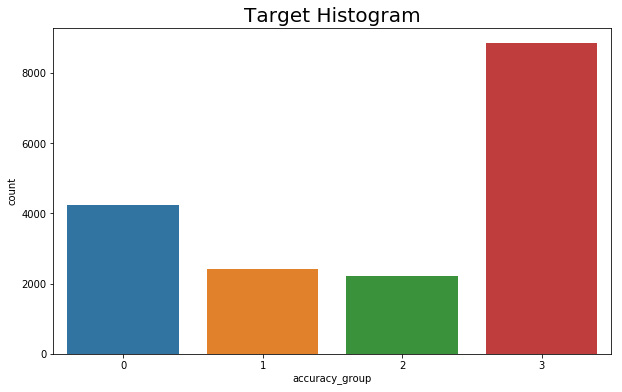

In [17]:
fig = plt.figure(figsize=(10,6))
plot = sns.countplot(train_data.accuracy_group)
plot.set_title('Target Histogram', fontsize=20)
plt.show()

In [18]:
test_data.to_csv('new_test_v19.csv', index=False)

## Data preprocessing

* column 삭제 : 'installation_id', 'game_session', 'timestamp' + 'num_correct', 'num_incorrect', 'accuracy'
* Target column : 'accuracy_group'
* categorical encoding : title

In [19]:
### Assessment dictionary
assess_list = {'Mushroom Sorter (Assessment)': 0, 
               'Bird Measurer (Assessment)': 1, 
               'Cauldron Filler (Assessment)': 2, 
               'Chest Sorter (Assessment)': 3,
               'Cart Balancer (Assessment)': 4}

In [20]:
del_clip = ['Welcome to Lost Lagoon!', 'Magma Peak - Level 1', 'Slop Problem',
       'Tree Top City - Level 1', 'Ordering Spheres', 'Costume Box',
       '12 Monkeys', 'Tree Top City - Level 2',"Pirate's Tale",
       'Treasure Map', 'Tree Top City - Level 3', 'Rulers',
       'Magma Peak - Level 2', 'Crystal Caves - Level 1', 'Balancing Act',
       'Crystal Caves - Level 2', 'Crystal Caves - Level 3',
       'Lifting Heavy Things', 'Honey Cake', 'Heavy, Heavier, Heaviest']

del_duration = train_data.columns[-40:][train_data.columns[-40:].str.contains('duration')]

In [21]:
def preprocess(train_data, test_data, assess_list= assess_list):
    ### 1. Assessment encoding
    train_data['title'] = train_data['title'].map(assess_list)
    test_data['title'] = test_data['title'].map(assess_list)
    
    ### ** Group ###
    group_train = train_data['title'].values
    group_test = test_data['title']
    
    ### 2. Make title column to dummy columns
    train_data = pd.concat([train_data, pd.get_dummies(train_data['title'], prefix='Assess_')], axis=1)
    test_data = pd.concat([test_data, pd.get_dummies(test_data['title'], prefix='Assess_')], axis=1)
    
    ### 3. Target column
    target = train_data['accuracy_group'].copy()

    ### 4. Drop columns
    train_data.drop(columns=(['installation_id', 'game_session', 'title',
                              'num_correct', 'num_incorrect', 'acc', 'accuracy_group']), inplace=True)
    test_data.drop(columns=(['installation_id', 'game_session', 'title']), inplace=True)
    
    ### 5. Drop previous Game features
    #as_cols = train_data.columns[train_data.columns.str.contains('Assessment')]
    train_data.drop(columns=del_clip, inplace=True, errors='ignore')
    test_data.drop(columns=del_clip, inplace=True, errors='ignore')
    train_data.drop(columns=del_duration, inplace=True, errors='ignore')
    test_data.drop(columns=del_duration, inplace=True, errors='ignore')
    
    return train_data, test_data, target, group_train, group_test

In [22]:
train_data, test_data, target, group_train, group_test = preprocess(train_data, test_data)

In [23]:
print_expand()
print(len(train_data.columns), len(test_data.columns))
display(train_data.head())
display(test_data.head())

288 288


,game_time,time_gap,total_time,time_percentage,Clip_time_per,Activity_time_per,Game_time_per,Assessment_time_per,session_count,Activity,Assessment,Clip,Game,between_3xxx,code_4xx_time,mushroom_p_count,bird_p_count,cauldron_p_count,chest_p_count,cart_p_count,mushroom_p_per,bird_p_per,cauldron_p_per,chest_p_per,cart_p_per,2000,2010,2020,2025,2030,2035,2040,2050,2060,2070,2075,2080,2081,2083,3010,3020,3021,4010,4020,4021,4022,4025,4030,4031,4035,4040,4045,4050,4070,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010,0_code_t,0_code_f,0_code_9,1_code_t,1_code_f,1_code_9,2_code_t,2_code_f,2_code_9,3_code_t,3_code_f,3_code_9,4_code_t,4_code_f,4_code_9,Scrub-A-Dub_count,Scrub-A-Dub_duration_x,Scrub-A-Dub_final,Scrub-A-Dub_final_duration_mean,Scrub-A-Dub_final_T_mean,Scrub-A-Dub_final_F_mean,Scrub-A-Dub_zero_T,Scrub-A-Dub_zero_F,Scrub-A-Dub_zero_duration,Scrub-A-Dub_process_T,Scrub-A-Dub_process_F,Scrub-A-Dub_process_Acc,All Star Sorting_count,All Star Sorting_duration_x,All Star Sorting_final,All Star Sorting_final_duration_mean,All Star Sorting_final_T_mean,All Star Sorting_final_F_mean,All Star Sorting_zero_T,All Star Sorting_zero_F,All Star Sorting_zero_duration,All Star Sorting_process_T,All Star Sorting_process_F,All Star Sorting_process_Acc,Air Show_count,Air Show_duration_x,Air Show_final,Air Show_final_duration_mean,Air Show_final_T_mean,Air Show_final_F_mean,Air Show_zero_T,Air Show_zero_F,Air Show_zero_duration,Air Show_process_T,Air Show_process_F,Air Show_process_Acc,Crystals Rule_count,Crystals Rule_duration_x,Crystals Rule_final,Crystals Rule_final_duration_mean,Crystals Rule_final_T_mean,Crystals Rule_final_F_mean,Crystals Rule_zero_T,Crystals Rule_zero_F,Crystals Rule_zero_duration,Crystals Rule_process_T,Crystals Rule_process_F,Crystals Rule_process_Acc,Dino Drink_count,Dino Drink_duration_x,Dino Drink_final,Dino Drink_final_duration_mean,Dino Drink_final_T_mean,Dino Drink_final_F_mean,Dino Drink_zero_T,Dino Drink_zero_F,Dino Drink_zero_duration,Dino Drink_process_T,Dino Drink_process_F,Dino Drink_process_Acc,Bubble Bath_count,Bubble Bath_duration_x,Bubble Bath_final,Bubble Bath_final_duration_mean,Bubble Bath_final_T_mean,Bubble Bath_final_F_mean,Bubble Bath_zero_T,Bubble Bath_zero_F,Bubble Bath_zero_duration,Bubble Bath_process_T,Bubble Bath_process_F,Bubble Bath_process_Acc,Dino Dive_count,Dino Dive_duration_x,Dino Dive_final,Dino Dive_final_duration_mean,Dino Dive_final_T_mean,Dino Dive_final_F_mean,Dino Dive_zero_T,Dino Dive_zero_F,Dino Dive_zero_duration,Dino Dive_process_T,Dino Dive_process_F,Dino Dive_process_Acc,Chow Time_count,Chow Time_duration_x,Chow Time_final,Chow Time_final_duration_mean,Chow Time_final_T_mean,Chow Time_final_F_mean,Chow Time_zero_T,Chow Time_zero_F,Chow Time_zero_duration,Chow Time_process_T,Chow Time_process_F,Chow Time_process_Acc,Pan Balance_count,Pan Balance_duration_x,Pan Balance_final,Pan Balance_final_duration_mean,Pan Balance_final_T_mean,Pan Balance_final_F_mean,Pan Balance_zero_T,Pan Balance_zero_F,Pan Balance_zero_duration,Pan Balance_process_T,Pan Balance_process_F,Pan Balance_process_Acc,Happy Camel_count,Happy Camel_duration_x,Happy Camel_final,Happy Camel_final_duration_mean,Happy Camel_final_T_mean,Happy Camel_final_F_mean,Happy Camel_zero_T,Happy Camel_zero_F,Happy Camel_zero_duration,Happy Camel_process_T,Happy Camel_process_F,Happy Camel_process_Acc,Leaf Leader_count,Leaf Leader_duration_x,Leaf Leader_final,Leaf Leader_final_duration_mean,Leaf Leader_final_T_mean,Leaf Leader_final_F_mean,Leaf Leader_zero_T,Leaf Leader_zero_F,Leaf Leader_zero_duration,Leaf Leader_process_T,Leaf Leader_process_F,Leaf Leader_process_Acc,Mushroom Sorter (Assessment)_count_t,Mushroom Sorter (Assessment)_count_f,Mushroom Sorter (Assessment)_count_acc,Mushroom Sorter (Assessment)_False_3,Mushroom Sorter (Assessment)_True_3,Mushroom Sorter (Assessment)_False_4,Mushroom Sorter (Assessment)_True_4,Mushroom Sorter (Assessment)_Acc,Mushroom Sorter (Assessment)_accuracy_group,Bird Measurer (Assess

,game_time,time_gap,total_time,time_percentage,Clip_time_per,Activity_time_per,Game_time_per,Assessment_time_per,session_count,Activity,Assessment,Clip,Game,between_3xxx,code_4xx_time,mushroom_p_count,bird_p_count,cauldron_p_count,chest_p_count,cart_p_count,mushroom_p_per,bird_p_per,cauldron_p_per,chest_p_per,cart_p_per,2000,2010,2020,2025,2030,2035,2040,2050,2060,2070,2075,2080,2081,2083,3010,3020,3021,4010,4020,4021,4022,4025,4030,4031,4035,4040,4045,4050,4070,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010,0_code_t,0_code_f,0_code_9,1_code_t,1_code_f,1_code_9,2_code_t,2_code_f,2_code_9,3_code_t,3_code_f,3_code_9,4_code_t,4_code_f,4_code_9,Scrub-A-Dub_count,Scrub-A-Dub_duration,Scrub-A-Dub_final,Scrub-A-Dub_final_duration_mean,Scrub-A-Dub_final_T_mean,Scrub-A-Dub_final_F_mean,Scrub-A-Dub_zero_T,Scrub-A-Dub_zero_F,Scrub-A-Dub_zero_duration,Scrub-A-Dub_process_T,Scrub-A-Dub_process_F,Scrub-A-Dub_process_Acc,All Star Sorting_count,All Star Sorting_duration,All Star Sorting_final,All Star Sorting_final_duration_mean,All Star Sorting_final_T_mean,All Star Sorting_final_F_mean,All Star Sorting_zero_T,All Star Sorting_zero_F,All Star Sorting_zero_duration,All Star Sorting_process_T,All Star Sorting_process_F,All Star Sorting_process_Acc,Air Show_count,Air Show_duration,Air Show_final,Air Show_final_duration_mean,Air Show_final_T_mean,Air Show_final_F_mean,Air Show_zero_T,Air Show_zero_F,Air Show_zero_duration,Air Show_process_T,Air Show_process_F,Air Show_process_Acc,Crystals Rule_count,Crystals Rule_duration,Crystals Rule_final,Crystals Rule_final_duration_mean,Crystals Rule_final_T_mean,Crystals Rule_final_F_mean,Crystals Rule_zero_T,Crystals Rule_zero_F,Crystals Rule_zero_duration,Crystals Rule_process_T,Crystals Rule_process_F,Crystals Rule_process_Acc,Dino Drink_count,Dino Drink_duration,Dino Drink_final,Dino Drink_final_duration_mean,Dino Drink_final_T_mean,Dino Drink_final_F_mean,Dino Drink_zero_T,Dino Drink_zero_F,Dino Drink_zero_duration,Dino Drink_process_T,Dino Drink_process_F,Dino Drink_process_Acc,Bubble Bath_count,Bubble Bath_duration,Bubble Bath_final,Bubble Bath_final_duration_mean,Bubble Bath_final_T_mean,Bubble Bath_final_F_mean,Bubble Bath_zero_T,Bubble Bath_zero_F,Bubble Bath_zero_duration,Bubble Bath_process_T,Bubble Bath_process_F,Bubble Bath_process_Acc,Dino Dive_count,Dino Dive_duration,Dino Dive_final,Dino Dive_final_duration_mean,Dino Dive_final_T_mean,Dino Dive_final_F_mean,Dino Dive_zero_T,Dino Dive_zero_F,Dino Dive_zero_duration,Dino Dive_process_T,Dino Dive_process_F,Dino Dive_process_Acc,Chow Time_count,Chow Time_duration,Chow Time_final,Chow Time_final_duration_mean,Chow Time_final_T_mean,Chow Time_final_F_mean,Chow Time_zero_T,Chow Time_zero_F,Chow Time_zero_duration,Chow Time_process_T,Chow Time_process_F,Chow Time_process_Acc,Pan Balance_count,Pan Balance_duration,Pan Balance_final,Pan Balance_final_duration_mean,Pan Balance_final_T_mean,Pan Balance_final_F_mean,Pan Balance_zero_T,Pan Balance_zero_F,Pan Balance_zero_duration,Pan Balance_process_T,Pan Balance_process_F,Pan Balance_process_Acc,Happy Camel_count,Happy Camel_duration,Happy Camel_final,Happy Camel_final_duration_mean,Happy Camel_final_T_mean,Happy Camel_final_F_mean,Happy Camel_zero_T,Happy Camel_zero_F,Happy Camel_zero_duration,Happy Camel_process_T,Happy Camel_process_F,Happy Camel_process_Acc,Leaf Leader_count,Leaf Leader_duration,Leaf Leader_final,Leaf Leader_final_duration_mean,Leaf Leader_final_T_mean,Leaf Leader_final_F_mean,Leaf Leader_zero_T,Leaf Leader_zero_F,Leaf Leader_zero_duration,Leaf Leader_process_T,Leaf Leader_process_F,Leaf Leader_process_Acc,Mushroom Sorter (Assessment)_count_t,Mushroom Sorter (Assessment)_count_f,Mushroom Sorter (Assessment)_count_acc,Mushroom Sorter (Assessment)_False_3,Mushroom Sorter (Assessment)_True_3,Mushroom Sorter (Assessment)_False_4,Mushroom Sorter (Assessment)_True_4,Mushroom Sorter (Assessment)_Acc,Mushroom Sorter (Assessment)_accuracy_group,Bird Measurer (Assessment)_count_t,Bird Mea

## Loss functions

In [24]:
# thanks to Andrew
def get_label(vector):
    vector[vector <= 1.12232214] = 0
    vector[np.where(np.logical_and(vector > 1.12232214, vector <= 1.73925866))] = 1
    vector[np.where(np.logical_and(vector > 1.73925866, vector <= 2.22506454))] = 2
    vector[vector > 2.22506454] = 3
    return vector

def cohen_kappa(y_pred, y):
    y = y.get_label().astype("int")
    y_pred = get_label(y_pred)
    loss = cohen_kappa_score(y, y_pred, weights = 'quadratic')
    return "cohen kappa score", loss, True

## Feature selection modeling

In [25]:
features = train_data.columns

In [26]:
#https://www.kaggle.com/ragnar123/adversarial-validation-and-model, Inline 8 function
def run_feature_selection(reduce_train, target, features, new_features, categoricals):
    '''
        Params
            reduct_train : train data
            target : target data
            features : data의 전체 feature
            new_features : 새로 만든 feature
            categoricals : categorical feature, lgb.Dataset을 만들 때 사용.
    '''
    
    # define lgbm hyperparammeters
    params = {
            'learning_rate': 0.1,
            'feature_fraction': 0.75,
            'subsample': 0.75,
            'n_jobs': -1,
            'seed': 50,
            'max_depth': 10
        }
    #
    X = reduce_train.values
    y = target.values
    
    # define a GroupKFold strategy because we are predicting unknown installation_ids
    kf = KFold(n_splits=5, shuffle=True, random_state=2019)
    #target = 'accuracy_group'
    oof_pred = np.zeros(len(reduce_train))
    important_features = pd.DataFrame()
    
    # train a baseline model and record the cohen cappa score as our best score
    for n_fold, (tr_idx, val_idx) in enumerate(kf.split(reduce_train)):
        print("="*50)
        print('Training Start, fold : {}'.format(n_fold+1))
        print("="*50)
        train_x, train_y = X[tr_idx], y[tr_idx]
        valid_x, valid_y = X[val_idx], y[val_idx]
        lgb_train = lgb.Dataset(train_x,train_y)
        lgb_valid = lgb.Dataset(valid_x,valid_y)
        
        model = lgb.train(params, lgb_train, num_boost_round = 100000, early_stopping_rounds = 100, 
                         valid_sets = [lgb_train, lgb_valid], verbose_eval = 500, feval = cohen_kappa)
        
        oof_pred[val_idx] = model.predict(valid_x)
        
        #Save feature importance
        fold_importance = pd.DataFrame()
        fold_importance['features'] = features
        fold_importance['importance'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
    # calculate loss
    loss_score = cohen_kappa_score(y, get_label(oof_pred), weights = 'quadratic')
    score = loss_score
        
    '''usefull_features = []
    for i in new_features:
        print('Our best cohen kappa score is :', score)
        oof_pred = np.zeros(len(reduce_train))
        print('Evaluating feature :', i)
        best_features = features + usefull_features + [i]
        print('Training with {} features'.format(len(best_features)))
        for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, groups = reduce_train['installation_id'])):
            print('Fold {}'.format(fold + 1))
            x_train, x_val = reduce_train[best_features].iloc[tr_ind], reduce_train[best_features].iloc[val_ind]
            y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
            train_set = lgb.Dataset(x_train, y_train, categorical_feature = categoricals)
            val_set = lgb.Dataset(x_val, y_val, categorical_feature = categoricals)

            model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 100, 
                                valid_sets=[train_set, val_set], verbose_eval = 500, feval = cohen_kappa)
            oof_pred[val_ind] = model.predict(x_val)
              
        loss_score = cohen_kappa_score(reduce_train[target], get_label(oof_pred), weights = 'quadratic')
        print('Our new cohen kappa score is : {}'.format(loss_score))
        
        if loss_score > score:
            print('Feature {} is usefull, adding feature to usefull feature list'.format(i))
            usefull_features.append(i)
            score = loss_score
        else:
            print('Feature {} is useless'.format(i))
        gc.collect()
        print('-'*50)
              
    usefull_features = features + usefull_features
    print('The best feature are: ', usefull_features)
    '''
    print('Our best cohen kappa score :', score)
              
    return model, important_features

In [27]:
model, important_features = run_feature_selection(train_data, target, features=features, new_features=False, categoricals=[])

Training Start, fold : 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's cohen kappa score: 0.722604	valid_1's cohen kappa score: 0.595332
Training Start, fold : 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's cohen kappa score: 0.771534	valid_1's cohen kappa score: 0.58122
Training Start, fold : 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	training's cohen kappa score: 0.694378	valid_1's cohen kappa score: 0.604469
Training Start, fold : 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's cohen kappa score: 0.702154	valid_1's cohen kappa score: 0.627908
Training Start, fold : 5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	training's cohen kappa score: 0.754681	valid_1's cohen k

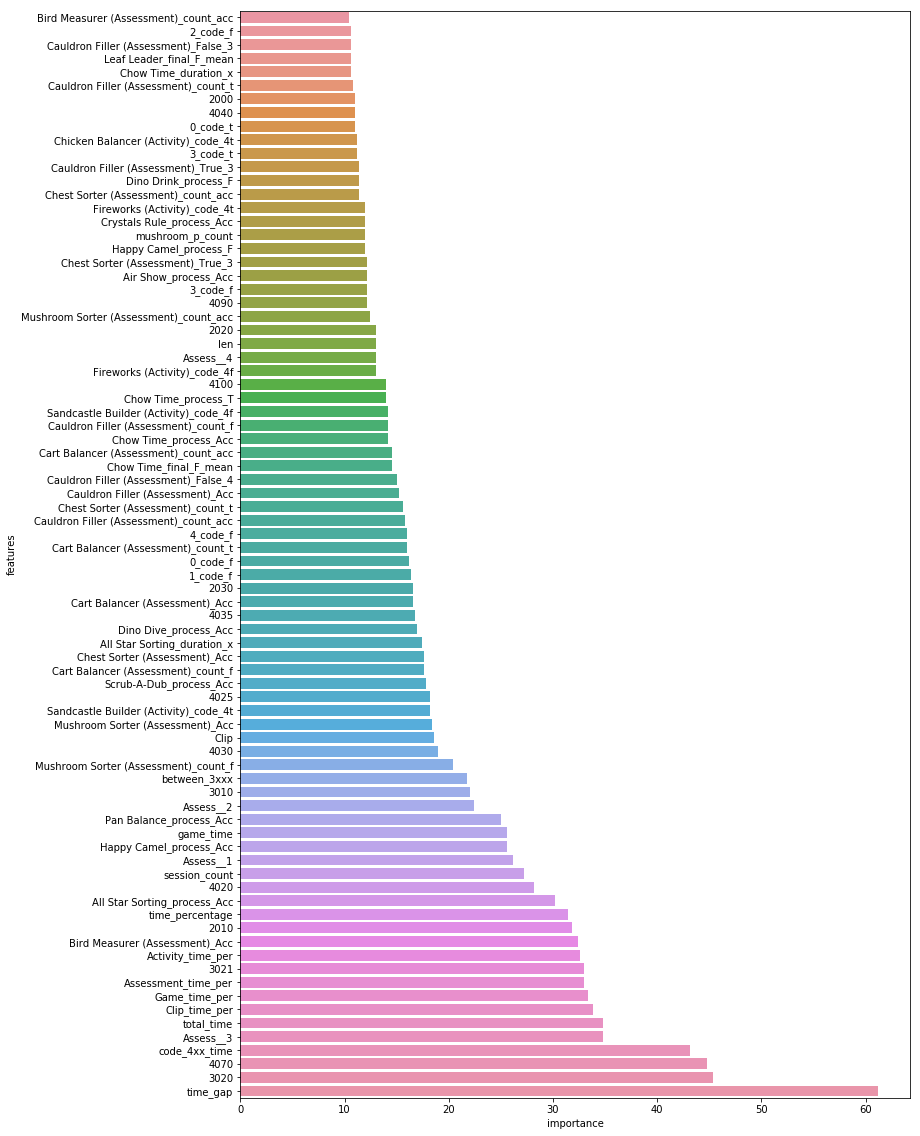

In [28]:
plt.figure(figsize=(12,20))
important_features = important_features.groupby('features')['importance'].mean().reset_index().sort_values('importance')
sns.barplot(important_features['importance'][-80:], important_features['features'][-80:])

In [29]:
#important_features.to_csv('important_features.csv')

## Modeling with lightGBM

In [30]:
import pickle

In [31]:
with open('../input/new-train/val_dict2.pkl', 'rb') as f:
    val_dict = pickle.load(f)

In [32]:
def run_lgb(reduce_train, target, reduce_test):

    params = {'verbose': 100,
          'learning_rate': 0.00911590137181596,
          'metric': 'rmse',
          'bagging_freq': 3,
          'boosting_type': 'gbdt',
          'eval_metric': 'cappa',
          'lambda_l1': 4.016887364081641,
          'colsample_bytree': 0.4236269531042225,
          'feature_fraction': 0.8095955674234223,
          'early_stopping_rounds': 200,
          'max_depth': 11,
          'min_data_in_leaf': 26,
          'lambda_l2': 4.508179249253482,
          'bagging_freq': 4,
          'bagging_fraction': 0.8577912738177631,
          'n_jobs': -1,
          'n_estimators': 2900,
          'objective': 'regression',
          'seed': 42}
    X = reduce_train.values
    y = target.values
    features = reduce_train.columns
    
    # define a GroupKFold strategy because we are predicting unknown installation_ids
    #kf = KFold(n_splits=5, shuffle=True, random_state=2019)
    #target = 'accuracy_group'
    oof_pred = np.zeros(len(reduce_train))
    oof_pred2 = np.zeros(len(reduce_train))
    train_pred = np.zeros(len(reduce_train))
    y_pred = np.zeros(len(reduce_test))
    important_features = pd.DataFrame()
    
    # train a baseline model and record the cohen cappa score as our best score
    #for n_fold, (tr_idx, val_idx) in enumerate(kf.split(reduce_train)):
    for n_fold in range(5):
        print("="*50)
        print('Training Start, fold : {}'.format(n_fold+1))
        print("="*50)
        val_idx = val_dict[n_fold]
        tr_idx = train_data.index[train_data.index.isin(val_idx) == False]
        
        train_x, train_y = X[tr_idx], y[tr_idx]
        valid_x, valid_y = X[val_idx], y[val_idx]
        lgb_train = lgb.Dataset(train_x,train_y)
        lgb_valid = lgb.Dataset(valid_x,valid_y)
        
        model = lgb.train(params, lgb_train, num_boost_round = 100000, early_stopping_rounds = 100, 
                         valid_sets = [lgb_train, lgb_valid], verbose_eval = 500, feval = cohen_kappa)
        
        oof_pred[val_idx] = model.predict(valid_x)
        try:
            oof_pred2[val_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
        except:
            print('pred2 errors!')
            pass
        
        train_pred += model.predict(reduce_train) / 5
        y_pred += model.predict(reduce_test) / 5
        
        #Save feature importance
        fold_importance = pd.DataFrame()
        fold_importance['features'] = features
        fold_importance['importance'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 1)
        
    # calculate loss
    loss_score = cohen_kappa_score(target, get_label(oof_pred), weights = 'quadratic')
    loss_score2 = cohen_kappa_score(target, get_label(oof_pred2), weights = 'quadratic')
    print('Our oof cohen kappa score is : {} and Best_iter : {}'.format(loss_score, loss_score2))
    print(pd.Series(get_label(oof_pred)).value_counts(normalize = True))
    return train_pred, y_pred, important_features

In [33]:
train_pred, y_pred, important_features = run_lgb(train_data, target, test_data)

Training Start, fold : 1
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 0.900501	training's cohen kappa score: 0.685693	valid_1's rmse: 0.989954	valid_1's cohen kappa score: 0.589789
Early stopping, best iteration is:
[420]	training's rmse: 0.913748	training's cohen kappa score: 0.674718	valid_1's rmse: 0.992294	valid_1's cohen kappa score: 0.592078
Training Start, fold : 2
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 0.904052	training's cohen kappa score: 0.681797	valid_1's rmse: 0.976631	valid_1's cohen kappa score: 0.61195
Early stopping, best iteration is:
[706]	training's rmse: 0.876696	training's cohen kappa score: 0.703397	valid_1's rmse: 0.973979	valid_1's cohen kappa score: 0.614167
Training Start, fold : 3
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 0.898455	training's cohen kappa score: 0.685999	valid_1's rmse: 0.997361	valid_1's cohen kappa score: 0.592751


In [34]:
important_features.to_csv('important_features.csv', index=False)

In [35]:
def predict(reduce_test, target, sample_submission, y_pred):
    # great a dict counter for each category
    dist = Counter(target)
    # normalize each 
    for k in dist:
        dist[k] /= len(target)
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)
        
    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred)))
    sample_submission['accuracy_group'] = y_pred.astype(int)
    #sample_submission.to_csv('submission.csv', index = False)
    print(sample_submission['accuracy_group'].value_counts(normalize = True))
    return sample_submission

In [36]:
sample_submission = predict(test_data, target, sample_submission, y_pred)

3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64


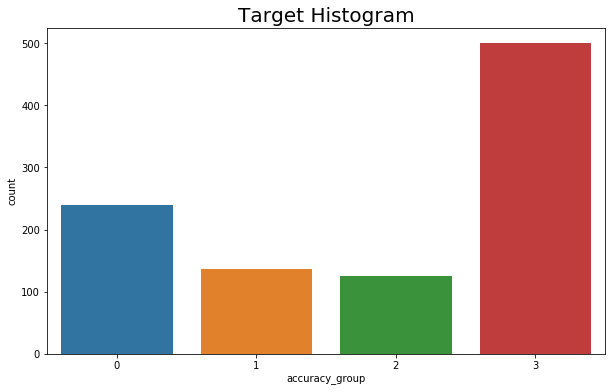

In [37]:
fig = plt.figure(figsize=(10,6))
plot = sns.countplot(sample_submission.accuracy_group)
plot.set_title('Target Histogram', fontsize=20)
plt.show()

## Len predict

In [38]:
def len_predict(game_log):
    if game_log['len'] <= 7:
        if game_log['title'] == 'Mushroom Sorter (Assessment)':
            return 3
        elif game_log['title'] == 'Bird Measurer (Assessment)':
            return 1
        elif game_log['title'] == 'Cauldron Filler (Assessment)':
            return 3
        elif game_log['title'] == 'Chest Sorter (Assessment)':
            return 0
        elif game_log['title'] == 'Cart Balancer (Assessment)':
            return 3
    else:
        return game_log['accuracy_group']

In [39]:
#for i,j in sample_submission.iterrows():
#    sample_submission.loc[i, 'accuracy_group'] = len_predict(j)

In [40]:
sample_submission.drop(columns=['len'], inplace=True)

In [41]:
sample_submission.drop(columns=['title'], inplace=True)

In [42]:
#sample_submission.drop(columns=['len', 'title'], inplace=True)
sample_submission['accuracy_group'] = sample_submission['accuracy_group'].astype(int)
sample_submission.to_csv('submission.csv', index = False)

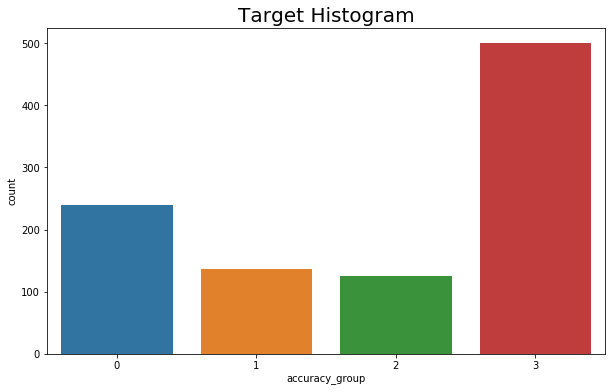

In [43]:
fig = plt.figure(figsize=(10,6))
plot = sns.countplot(sample_submission.accuracy_group)
plot.set_title('Target Histogram', fontsize=20)
plt.show()